## From paper: **Identification and Control of Dynamical Systems Using Neural Networks 1990**

### Example 3


In [100]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim



# plant dynamics or f(y) and g(u) these "we" (the NN) trys to learn
def f(y):
    return y / (1 + y**2)

def g(u):
    return u**3

# NN mlp architecture [1,20,10,1]
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )
    
    def forward(self, x):
        return self.nn(x)


In [101]:

# Plant to gen true data
def simulate_plant(u):
    y = [0.0]
    for k in range(len(u)-1):
        next_y = f(y[k]) + g(u[k])
        y.append(next_y)
    return np.array(y)

#  generationg train data 
def generate_training_data(n_samples=100000):
    u_train = np.random.uniform(-2, 2, n_samples + 1)
    y_train = simulate_plant(u_train)
    return u_train[:-1], y_train


In [ ]:
# init models
nn_f = NN()
nn_g = NN()

optimizer_f = optim.Adam(nn_f.parameters(), lr=0.1)
optimizer_g = optim.Adam(nn_g.parameters(), lr=0.1)

u_train, y_train = generate_training_data()

u_tensor = torch.tensor(u_train.reshape(-1, 1), dtype=torch.float32)
y_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

#train models
n_epochs = 50
for epoch in range(n_epochs):
    f_pred = nn_f(y_tensor[:-1])
    g_pred = nn_g(u_tensor)
    y_pred = f_pred + g_pred
    y_next = y_tensor[1:]
    
    loss = nn.MSELoss()(y_pred, y_next)
    
    optimizer_f.zero_grad()
    optimizer_g.zero_grad()
    loss.backward()
    optimizer_f.step()
    optimizer_g.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 1.072014
Epoch [20/50], Loss: 0.390710
Epoch [30/50], Loss: 0.144076
Epoch [40/50], Loss: 0.025863
Epoch [50/50], Loss: 0.018747


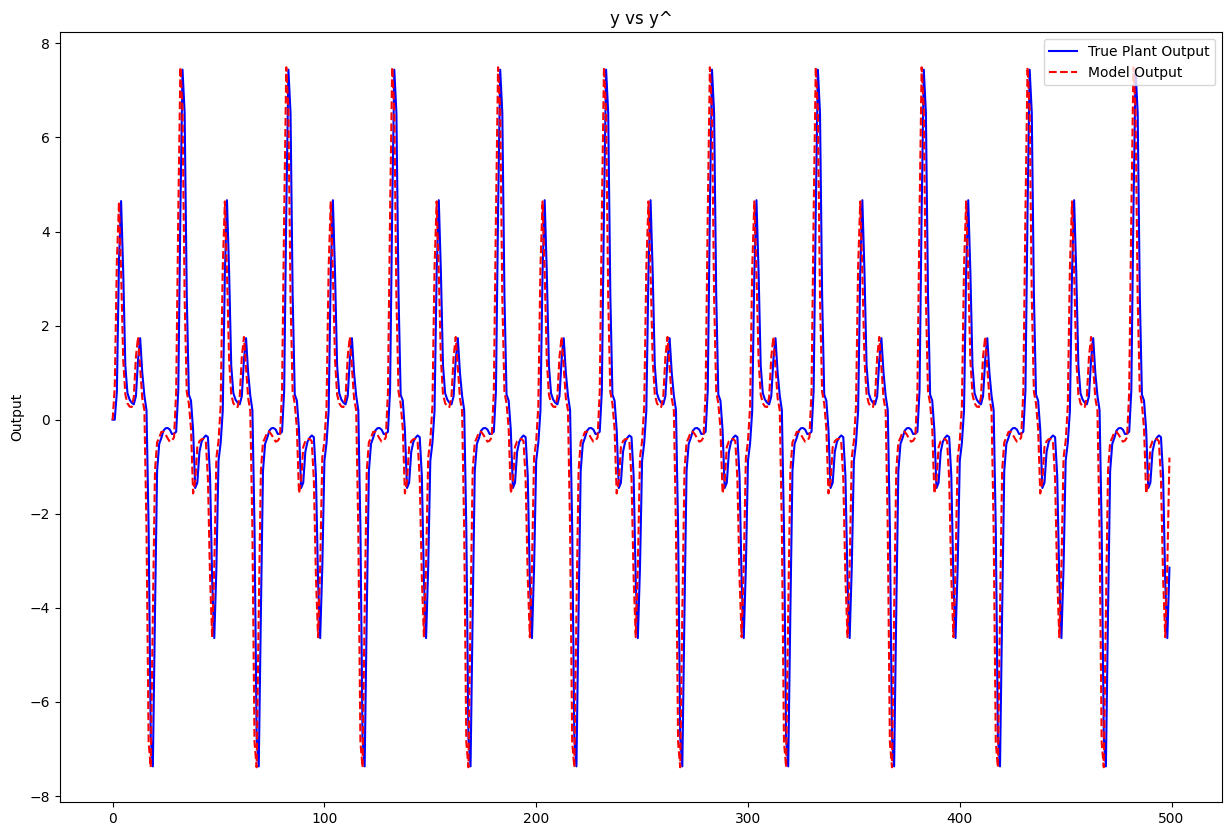

In [ ]:

# eval
t = np.arange(1000)
u_test = np.sin(2*np.pi*t/25) + np.sin(2*np.pi*t/10)
y_true = simulate_plant(u_test)

y_pred = []
y_current = y_true[0]

with torch.no_grad():
    for k in range(len(u_test)-1):
        f_out = nn_f(torch.FloatTensor([[y_current]])).item()
        g_out = nn_g(torch.FloatTensor([[u_test[k]]])).item()
        y_next = f_out + g_out
        y_pred.append(y_next)
        y_current = y_next

y_pred = np.array(y_pred)

plt.figure(figsize=(15, 10))
plt.plot(t[:-500], y_true[:-500], 'b-', label='True Plant Output')
plt.plot(t[:-500], y_pred[:-499], 'r--', label='Model Output')
plt.title('y vs y^')
plt.legend()
plt.ylabel('Output')
plt.show()



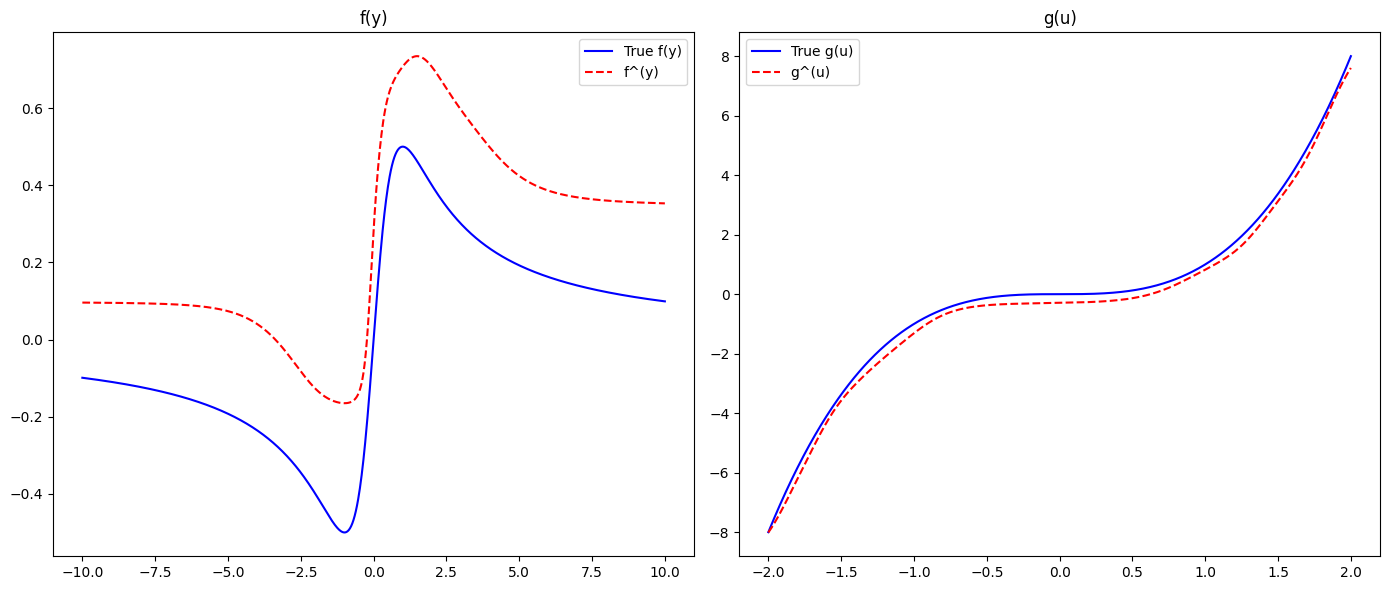

In [104]:

# viz the functions we learned 
y_test = np.linspace(-10, 10, 1000)
u_test = np.linspace(-2, 2, 1000)

with torch.no_grad():
    f_learned = nn_f(torch.Tensor(y_test.reshape(-1, 1))).numpy()
    g_learned = nn_g(torch.Tensor(u_test.reshape(-1, 1))).numpy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, f(y_test), 'b-', label='True f(y)')
plt.plot(y_test, f_learned, 'r--', label='f^(y)')
plt.title('f(y)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(u_test, g(u_test), 'b-', label='True g(u)')
plt.plot(u_test, g_learned, 'r--', label='g^(u)')
plt.title('g(u)')
plt.legend()

plt.tight_layout()
plt.show()